In [6]:
###加载相应的模块
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import numpy as np
import xlrd
import pandas as pd
import sys
import logging##使用日志显示一些输出

In [7]:
def gamma(im_channel):
    tmp=np.zeros((im_channel.shape))
    for i in range(im_channel.shape[0]):
        for j in range(im_channel.shape[1]):
            tmp[i,j]=((im_channel[i,j]+0.055)/1.055)**2.4 if im_channel[i,j] > 0.04045 else im_channel[i,j] / 12.92
    return tmp
def f(im_channel):
    tmp=np.zeros((im_channel.shape))
    for i in range(im_channel.shape[0]):
        for j in range(im_channel.shape[1]):
            tmp[i,j]=im_channel[i,j]**1/3 if im_channel[i,j] > 0.008856 else 7.787 * im_channel[i,j] + 0.137931
    return tmp
    # return im_channel**1/3 if im_channel > 0.008856 else 7.787 * im_channel + 0.137931
def split_rgb(img):
    b,g,r=cv2.split(img)
    return r,g,b
def getInt(arr):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            arr[i,j]=int(arr[i,j])
    return arr

In [8]:
# RGB与Lab转换
def convert_image(image):
    L_ = np.zeros((image.shape[0], image.shape[1]), dtype=np.int32)
    a_ = np.zeros((image.shape[0], image.shape[1]), dtype=np.int32)
    b_ = np.zeros((image.shape[0], image.shape[1]), dtype=np.int32)
    r, g, b = split_rgb(image)
    R = gamma(r / 255.0)
    G = gamma(g / 255.0)
    B = gamma(b / 255.0)

    X = 0.412453 * R + 0.357580 * G + 0.180423 * B
    Y = 0.212671 * R + 0.715160 * G + 0.072169 * B
    Z = 0.019334 * R + 0.119193 * G + 0.950227 * B

    X /= (0.950456)
    Y /= (1.0)
    Z /= (1.088754)

    FX = f(X)
    FY = f(Y)
    FZ = f(Z)
    print("X.shape:",X.shape)
    tmp = np.zeros((Y.shape))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            L_[i, j] = 116 * FY[i, j] - 16 if Y[i, j] > 0.008856 else 903.3 * Y[i, j]
    print("L_.shape:",L_.shape)
    a_ = 500 * (FX - FY)
    a_ = getInt(a_)
    print("a_.shape:",a_.shape)
    b_ = 200 * (FY - FZ)
    b_ = getInt(b_)
    print("b_.shape:",b_.shape)
    return L_, a_, b_

In [9]:
def getMaxMin(L):#寻找最大的以及最小的
    max=0
    min=256
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            if L[i,j]>max:
                max=L[i,j]
            elif L[i,j]<min:
                min=L[i,j]
    return max,min
def getMaxmax(arr):##寻找最大的
    mmax=0
    for i in range(len(arr)):
        if arr[i]>mmax:
            mmax=arr[i]
    return mmax

def getMaxmax_(arr):##找二维数组中的最小的 
    mmax=0
    for i in range(len(arr)):
        if arr[i][0]>mmax:
            mmax=arr[i][0]
    return mmax

def getMinmin(arr):#最小值
    mmin=1e5
    for i in range(len(arr)):
        if arr[i]<mmin:
            mmin=arr[i]
    return mmin

def getNor(x,diff):
    tmp=np.zeros((x.shape[0],x.shape[1]))
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            tmp[i,j]=int(x[i,j]+diff)
    return tmp


def distribute(L, a, b):
    L_max, L_min = getMaxMin(L)
    a_max, a_min = getMaxMin(a)
    b_max, b_min = getMaxMin(b)
    #     print(L_max,' ',L_min)
    #     print(a_max,' ',a_min)
    #     print(b_max,' ',b_min)

    #     print('L',L)
    #     print('a',a)
    #     print('b',b)
    getMax = getMaxmax([L_max, a_max, b_max])
    getMin = getMinmin([L_min, a_min, b_min])
    diff = int(getMax - getMin)#最大值和最小值之间的差
    L_nor = getNor(L, diff)
    a_nor = getNor(a, diff)
    b_nor = getNor(b, diff)###将这三个数值都变成正数
    #     print('L_nor',L_nor)
    #     print('a_nor',a_nor)
    #     print('b_nor',b_nor)
    ###新增加的部分
    L = L_nor[:,:,np.newaxis]##重新增加第三个维度
    a=a_nor[:,:,np.newaxis]
    b=b_nor[:,:,np.newaxis]
    m=np.concatenate([L,a,b],axis=2)
    m=m.reshape(len(L)*len(L[0]),3)###设置成为256*256，3的尺寸
    pre_lab=m##rgb表示rgb图像的像素数值
    ####***************
    L_max, L_min = getMaxMin(L_nor)
    a_max, a_min = getMaxMin(a_nor)
    b_max, b_min = getMaxMin(b_nor)

    #     print(getMax,' ',getMin)
    num = int(diff + getMax)

    QG = np.zeros([num + 1, num + 1, num + 1])
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            a=int(L_nor[i, j])
            b=int(a_nor[i, j])
            c=int(b_nor[i, j])
            tmp=QG[a, b, c]
            QG[a, b, c] = tmp + 1###表示在这个位置的点的个数
    return QG,diff,pre_lab

def Normal_distribution(x):#正态分布
    e=2.71828
    pi=3.1415926
    def f(x):
        index=(-(x**2/2))
        e_exp=e**index
        f=(1/((2*pi)**0.5))*e_exp
        return f
    return f(x)/f(0)



def density(c,lab,list):#在lab的以c为半径的球体范围内，有多少点
    amount=0
    ly=lab[0]
    ay=lab[1]
    by=lab[2]
    for i in range(len(list)):
        tmp=list[i]
        l=tmp[0]
        a=tmp[1]
        b=tmp[2]
        dis=math.sqrt((ly-l)**2+(ay-a)**2+(by-b)**2)
        if dis<c:
            amount+=tmp[3]*Normal_distribution(dis)
            # amount+=tmp[3]
    return amount

def distance(lab,list):#计算数值距离
    min=1e15
    lab_num=lab[1]
    for i in range(len(list)):
        curr_num=list[i][1]
        if lab_num<curr_num:
            ly=lab[0][0]
            ay=lab[0][1]
            by=lab[0][2]
            l=list[i][0][0]
            a=list[i][0][1]
            b=list[i][0][2]
            dis=math.sqrt((ly-l)**2+(ay-a)**2+(by-b)**2)
            if (dis<min) & (dis!=0):
                min=dis
    return min


def w(rho, delta):
    w=[]
    for i in range(len(rho)):
        a = int(rho[i][1])
        b = int(delta[i][0])
        w.append([a*b])
    return w

In [10]:
#### 预处理距离，将其转换成为二维数组
def coordinate(train):
    pre_coordinate=train["Lab"]
    coordinate=[]
    ##准备一个存放距离的列表
    for i in range(len(pre_coordinate)):
        coordinate.append(list(map(float,pre_coordinate[i].lstrip('[').rstrip(']').split(','))))
    #### 表示一下所有的中心点二维数组
    return coordinate

In [11]:
#### 接下来进行一次遍历，找到每一个点属于的簇心
def closeLeader(coord,chose_list,rho):
    ###只需传入每一个点的坐标即可
    close_leader = np.zeros(shape=len(coord), dtype=np.int32)
    ####表示每一个点最近的簇心
    for i in range(len(coord)):
        if i in list(chose_list):
            close_leader[i]=i
            continue
        minDis=Distance(coord[i],coord[chose_list[0]])
        index=chose_list[0]
        for j in list(chose_list):
            if  rho[j]>rho[i]:
                dis=Distance(coord[i],coord[j])
                if dis<minDis:
                    minDis=dis
                    index=j
        close_leader[i]=index
    return close_leader

In [12]:
#### 根据rho以及delta选出簇心
def show_optionmal(rho, delta):
    plt.figure(num=1, figsize=(8, 5))
    for i in range(len(rho)):
        plt.scatter(x=rho[i], y=delta[i], c='k', marker='o', s=50)
    plt.xlabel('rho')
    plt.ylabel('delta')
    plt.title(r'Decision Graph ')
    plt.show()

In [13]:
# 确定类别点,计算每点的密度值与最小距离值的乘积，并画出决策图，以供选择将数据共分为几个类别
def show_nodes_for_chosing_mainly_leaders(w):
    w=-np.sort(-w)
    w=w[1:]
    plt.figure(num=1, figsize=(8, 5))
    plt.scatter(x=range(len(w)), y=-np.sort(-w), c='k', marker='o')
    plt.xlabel('data_num')
    plt.ylabel('w')
    plt.title('Guarantee The Leader')
    plt.show()

In [14]:
#### 计算两点之间距离
def Distance(vec1,vec2):
    vec1=np.mat(vec1)
    vec2=np.mat(vec2)
    return np.sqrt(np.sum(np.power(vec1-vec2, 2)))

In [15]:
####接下来开始进行画图
###这个标识绘制结果图
from mpl_toolkits.mplot3d import Axes3D
def show_result3(close_leader, coordinate, chose_list):
    norm_data=coordinate
    colors = [ '#000000', 
              '#006400', '#EE82EE', '#FFA500','#00FFFF',   
              '#228B22', '#FFFF00','#FFA500','#FFFACD',
              '#00FF00', '#0000FF', '#FF0000', 
              '#0000FF', '#FF1493',
              ]
    # 画最终聚类效果图
    leader_color = {}
    ####这是所有的簇心点的下标数值
    for index, i in enumerate(chose_list):
        leader_color[i] = index
        ####i的颜色是index//表示一共有这么几种颜色
    #plt.figure(num=1, figsize=(15, 10),projection='3d')
    ax = plt.subplot(111, projection='3d')  # 创建一个三维的绘图工程
    ####再搞一个画框
    for node, class_ in enumerate(close_leader):
        #  标出每一类的聚类中心点
        if node in chose_list:
            ax.scatter(norm_data[node, 0],norm_data[node, 1],norm_data[node, 2], marker='+', s=500, c='K', alpha=1)
            
        else:
            ax.scatter(norm_data[node, 0],norm_data[node, 1],norm_data[node, 2],c=colors[leader_color[class_]], s=1, marker='o', alpha=1)
  
    plt.title('The Result Of Cluster')
    '''
    plt.xlim(norm_data[node, 0].min(),norm_data[node, 0].max())
    plt.ylim(norm_data[node, 1].min(),norm_data[node, 1].max())
    plt.zlim(norm_data[node, 2].min(),norm_data[node, 2].max())
    '''
    #plt.xlim(-10,10)
    #plt.ylim(-10,5)
    plt.show()

In [30]:

def process(arg1,arg2):

    train = pd.read_csv(arg1)
    ###一、找到所有坐标形成的二维矩阵
    pre_coord=coordinate(train)
    coord2=np.array(pre_coord)
    coord=np.mat(pre_coord)
    coord1=list(pre_coord)
    org=cv2.imread(arg2)[:,:,0:3]
    org_pic=plt.imread(arg2)[:,:,0:3]
    """
    有一些图片是四个通道，这一条语句可以实现取前几个通道的目的
    """
    """
    解释一下为什么这里准备了两个org以及org_pic:
    cv2的数据存储图片的方式是BGR，因为师姐使用的是cv2转的，所以pre_lab的生成需要使用org而不是org_pic
    """
    #cv2.imshow('lena',org)
    L,a,b=convert_image(org)
    QG,num,pre_lab=distribute(L,a,b)#分别为分布函数和用于将矩阵的所有负值调回正值使用的数，以及lab数值
    ####二、进行映射，将Lab映射成去重之后的数组
    """
    pre_lab和真正的rgb图像具有相同的index表示；
    lab是一个数组lab[i]=j,i是pre_lab中的index,j是QG_notNull中的index,lab数组是为了将两者联系起来

    """
    lab=[]
    rgb=np.zeros(len(coord2))
    for i in range(len(pre_lab)):
        l=pre_lab[i][0]#三维数组
        a=pre_lab[i][1]
        b=pre_lab[i][2]
        for j in range(len(coord2)):  
            tmp=coord2[j]
            if(l==tmp[0] and a==tmp[1] and b==tmp[2]):
                lab.append(j)
                rgb[j]=i
                break
    print("找到所有坐标形成的二维矩阵")
    ###二、找到这些数据
    rho=train["rho"]
    delta=train["delta"]
    w=train["w"]
    print("找到这些数据")
    ###三、展示决策图
    show_optionmal(rho, delta)
    show_nodes_for_chosing_mainly_leaders(w)
    print("展示决策图")
    ###四、进行簇心的选择，包括簇心的个数以及坐标的位置
    leaders_num = int(input('input clusters num'))  # 根据以上的数据处理,输入最终选择的司令数目
    chose_list = np.argsort(-w)[: leaders_num]  # 选择一下这些点，选出最大的几个
    chose_list=list(chose_list)### 如果不加上这一个结果会很诡异
    print('mianly leaders:', chose_list)
    print("选择簇心")
    ####五、找到每一个点对应的簇心，形成一个列表
    close_leader=list(closeLeader(coord,chose_list,rho))
    logging.info("找到每一个点对应的簇心并形成一个列表")
    ###增加一列
    train["close_coord"]=[coord2[i].astype(int) for i in close_leader]
    print("修改之后的列表显示")
    print(train.head(10))
    print("增加一列")
    ### 六、画图显示
    show_result3(close_leader, coord, chose_list)
    print("画图显示")
    #### 七、图片的显示，再转换成rgb并显示
    plt.imshow(org_pic)#显示原有的图片
    plt.show()
    copy_pic=org_pic.copy()##复制出来的文件，可以进行修改的
    copy_pic1=copy_pic.reshape(len(org_pic)*len(org_pic[0]),3)
    for i in range(len(copy_pic)):
        for j in range(len(copy_pic[0])):
            index=i*len(copy_pic[0])+j
            tmp=copy_pic1[rgb[close_leader[lab[index]]].astype(int)]
            copy_pic[i][j]=tmp#复制图像的修改
    plt.imshow(copy_pic)
    plt.show()
    print("显示分类之后的图片")

**************------------lena.jpg-------------*************************
X.shape: (256, 256)
L_.shape: (256, 256)
a_.shape: (256, 256)
b_.shape: (256, 256)
找到所有坐标形成的二维矩阵
找到这些数据


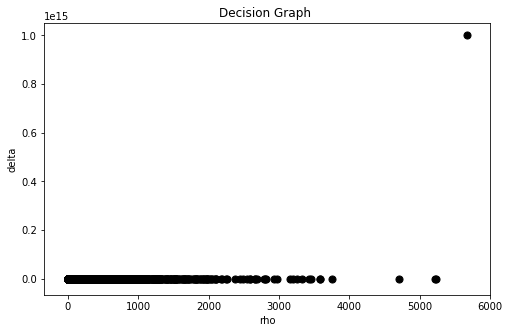

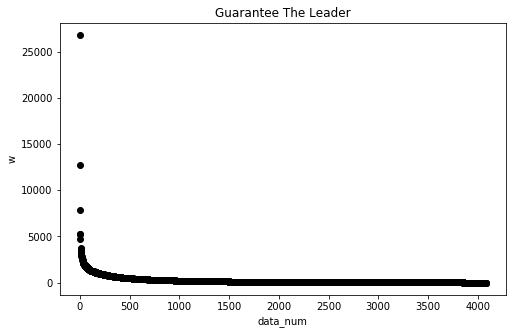

展示决策图
input clusters num7
mianly leaders: [47, 355, 807, 1508, 55, 46, 54]
选择簇心
修改之后的列表显示
               Lab         rho  delta   Q      w      close_coord
0  [124, 140, 100]    5.076864    1.0   1    5.0  [125, 143, 138]
1  [124, 140, 101]    8.040173    1.0   1    8.0  [125, 143, 138]
2  [124, 140, 102]    9.080521    1.0   2    9.0  [125, 143, 138]
3  [124, 140, 103]    7.093120    1.0   1    7.0  [125, 143, 138]
4  [124, 140, 104]    4.859221    1.0   1    4.0  [125, 143, 138]
5  [124, 140, 105]    3.616639    1.0   1    3.0  [125, 143, 138]
6  [124, 140, 138]  333.081885    1.0   1  333.0  [125, 143, 138]
7  [124, 140, 139]  389.994365    1.0  20  389.0  [125, 143, 139]
8   [124, 141, 99]    3.904532    1.0   1    3.0  [125, 143, 138]
9  [124, 141, 100]    8.381002    1.0   1    8.0  [125, 143, 138]
增加一列


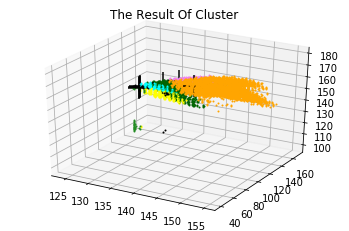

画图显示


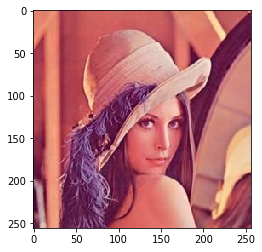

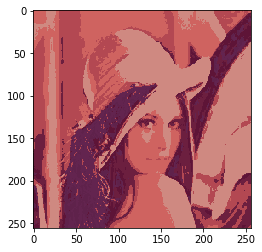

显示分类之后的图片


In [31]:
print("**************------------lena.jpg-------------*************************")
process("./lena.csv","./lena.jpg")

**************------------nature.jpg-------------*************************
X.shape: (313, 500)
L_.shape: (313, 500)
a_.shape: (313, 500)
b_.shape: (313, 500)
找到所有坐标形成的二维矩阵
找到这些数据


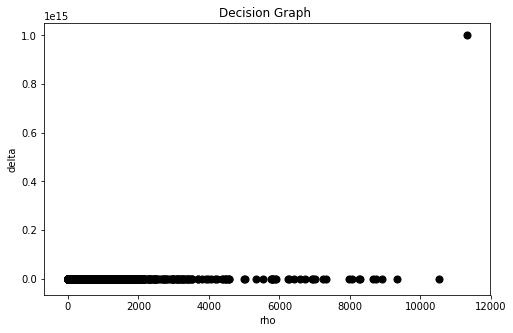

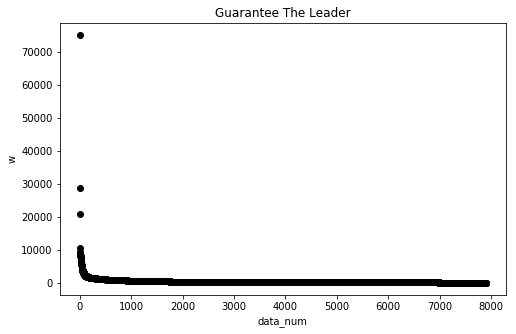

展示决策图
input clusters num4
mianly leaders: [7418, 115, 4197, 769]
选择簇心
修改之后的列表显示
               Lab          rho  delta   Q       w      close_coord
0  [187, 201, 163]    33.969978    1.0   1    33.0  [202, 194, 193]
1  [187, 201, 164]    41.100782    1.0   3    41.0  [202, 194, 193]
2  [187, 201, 166]    43.150989    1.0   2    43.0  [202, 194, 193]
3  [187, 201, 167]    45.126564    1.0   1    45.0  [202, 194, 193]
4  [187, 201, 168]    41.751939    1.0   2    41.0  [202, 194, 193]
5  [187, 201, 170]    27.573713    1.0   1    27.0  [202, 194, 193]
6  [187, 201, 202]  1555.569778    1.0  29  1555.0  [188, 202, 202]
7  [187, 201, 203]  1082.362424    1.0   3  1082.0  [188, 202, 202]
8  [187, 202, 162]    27.488365    1.0   5    27.0  [202, 194, 193]
9  [187, 202, 163]    54.236788    1.0  27    54.0  [202, 194, 193]
增加一列


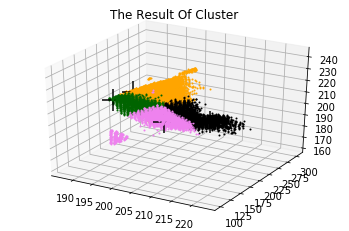

画图显示


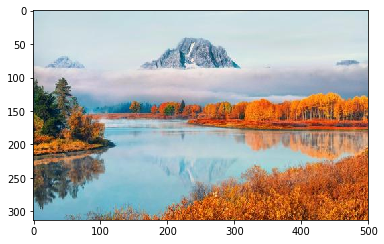

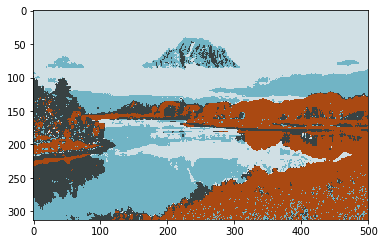

显示分类之后的图片


In [32]:
print("**************------------nature.jpg-------------*************************")
process("./nature.csv","./nature.jpg")

**************-------------streetview------------*************************
X.shape: (500, 748)
L_.shape: (500, 748)
a_.shape: (500, 748)
b_.shape: (500, 748)
找到所有坐标形成的二维矩阵
找到这些数据


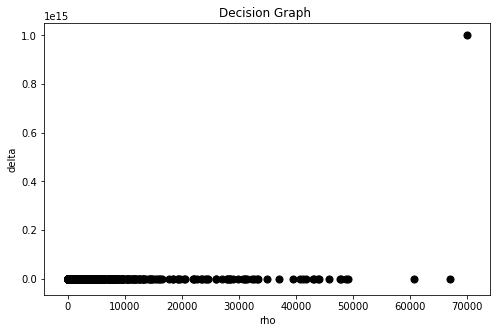

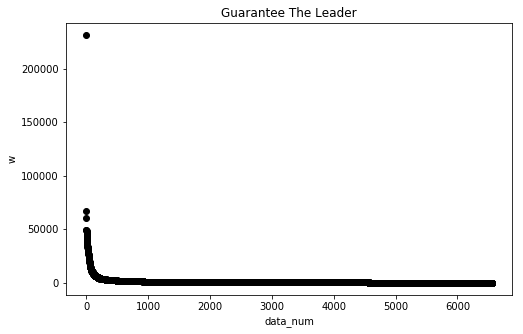

展示决策图
input clusters num4
mianly leaders: [157, 6481, 91, 251]
选择簇心
修改之后的列表显示
               Lab          rho      delta    Q        w      close_coord
0  [187, 202, 162]   783.941646   1.000000  338    783.0  [188, 202, 202]
1  [187, 202, 163]  1143.561604  34.928498  600  38862.0  [188, 202, 202]
2  [187, 202, 164]  1076.084294   1.000000  446   1076.0  [188, 202, 202]
3  [187, 202, 165]   785.577393   1.000000  274    785.0  [188, 202, 202]
4  [187, 202, 166]   548.125726   1.000000  176    548.0  [188, 202, 202]
5  [187, 202, 167]   403.498871   1.000000  164    403.0  [188, 202, 202]
6  [187, 202, 168]   285.841819   1.000000   95    285.0  [188, 202, 202]
7  [187, 202, 169]   193.847688   1.000000   62    193.0  [188, 202, 202]
8  [187, 202, 170]   135.315486   1.000000   46    135.0  [188, 202, 202]
9  [187, 202, 171]    93.487582   1.000000   31     93.0  [188, 202, 202]
增加一列


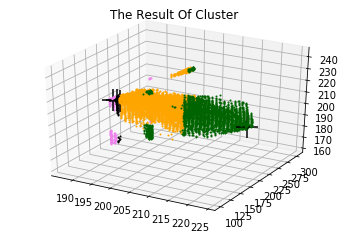

画图显示


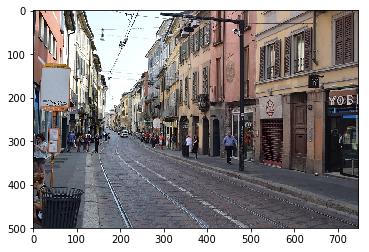

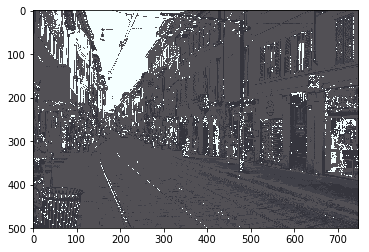

显示分类之后的图片


In [33]:
print("**************-------------streetview------------*************************")
process("./streetview.csv","./streetview.jpg")

**************----------lung_cancer.jpg---------------*************************
X.shape: (320, 322)
L_.shape: (320, 322)
a_.shape: (320, 322)
b_.shape: (320, 322)
找到所有坐标形成的二维矩阵
找到这些数据


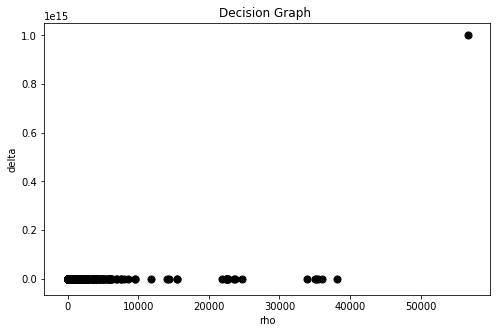

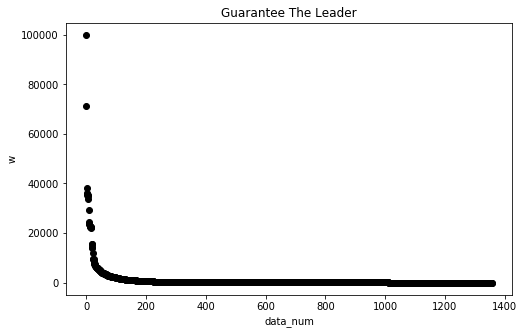

展示决策图
input clusters num9
mianly leaders: [730, 4, 25, 720, 823, 743, 729, 731, 671]
选择簇心
修改之后的列表显示
               Lab          rho  delta     Q        w      close_coord
0  [126, 141, 101]   677.513338    1.0   150    677.0  [126, 141, 105]
1  [126, 141, 102]  1362.378349    1.0   414   1362.0  [126, 141, 105]
2  [126, 141, 103]  2045.258684    1.0   480   2045.0  [126, 141, 105]
3  [126, 141, 104]  2557.937498    1.0   852   2557.0  [126, 141, 105]
4  [126, 141, 105]  2772.854524   36.0   891  99792.0  [126, 141, 105]
5  [126, 141, 106]  2598.991727    1.0  1084   2598.0  [126, 141, 105]
6  [126, 141, 107]  1855.737881    1.0   722   1855.0  [126, 141, 105]
7  [126, 141, 108]   896.638390    1.0   136    896.0  [126, 141, 105]
8  [126, 141, 109]   316.301498    1.0    25    316.0  [126, 141, 105]
9  [126, 141, 110]   131.435373    1.0     7    131.0  [126, 141, 105]
增加一列


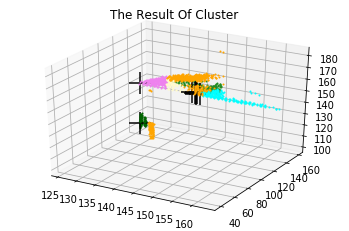

画图显示


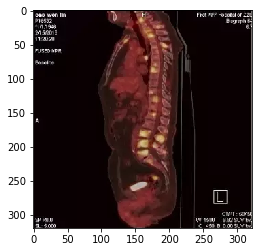

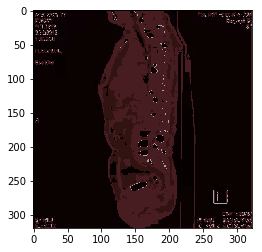

显示分类之后的图片


In [34]:
print("**************----------lung_cancer.jpg---------------*************************")
process("./lung_cancer.csv","./lung_cancer.png")

#### 经过观察发现，决策图中第一个点比较突出，感觉影响判断，所以希望从第二个开始进行判断，以下是修改之后的程序

In [19]:
# 确定类别点,计算每点的密度值与最小距离值的乘积，并画出决策图，以供选择将数据共分为几个类别
def show_nodes_for_chosing_mainly_leaders(w):
    w=-np.sort(-w)
    w=w[2:]
    plt.figure(num=1, figsize=(8, 5))
    plt.scatter(x=range(len(w)), y=-np.sort(-w), c='k', marker='o')
    plt.xlabel('data_num')
    plt.ylabel('w')
    plt.title('Guarantee The Leader')
    plt.show()

**************------------lena.jpg-------------*************************
X.shape: (256, 256)
L_.shape: (256, 256)
a_.shape: (256, 256)
b_.shape: (256, 256)
找到所有坐标形成的二维矩阵
找到这些数据


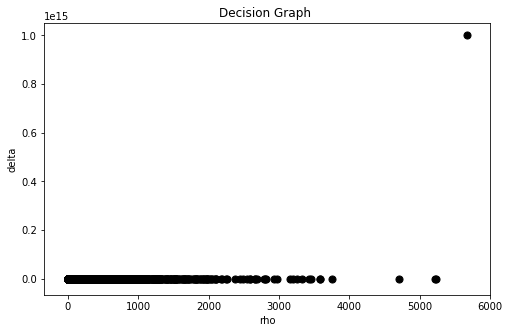

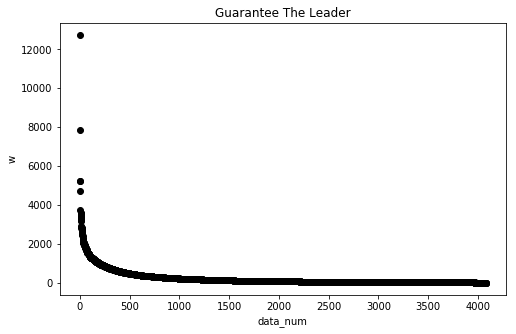

展示决策图
input clusters num6
mianly leaders: [47, 355, 807, 1508, 55, 46]
选择簇心
修改之后的列表显示
               Lab         rho  delta   Q      w      close_coord
0  [124, 140, 100]    5.076864    1.0   1    5.0  [125, 143, 138]
1  [124, 140, 101]    8.040173    1.0   1    8.0  [125, 143, 138]
2  [124, 140, 102]    9.080521    1.0   2    9.0  [125, 143, 138]
3  [124, 140, 103]    7.093120    1.0   1    7.0  [125, 143, 138]
4  [124, 140, 104]    4.859221    1.0   1    4.0  [125, 143, 138]
5  [124, 140, 105]    3.616639    1.0   1    3.0  [125, 143, 138]
6  [124, 140, 138]  333.081885    1.0   1  333.0  [125, 143, 138]
7  [124, 140, 139]  389.994365    1.0  20  389.0  [125, 143, 139]
8   [124, 141, 99]    3.904532    1.0   1    3.0  [125, 143, 138]
9  [124, 141, 100]    8.381002    1.0   1    8.0  [125, 143, 138]
增加一列


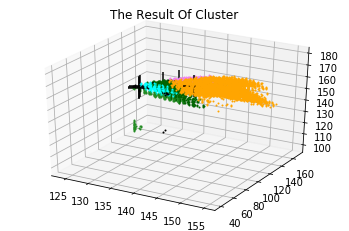

画图显示


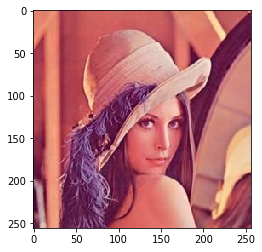

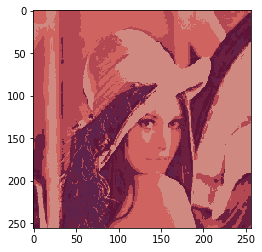

显示分类之后的图片


In [20]:
print("**************------------lena.jpg-------------*************************")
process("./lena.csv","./lena.jpg")

**************------------nature.jpg-------------*************************
X.shape: (313, 500)
L_.shape: (313, 500)
a_.shape: (313, 500)
b_.shape: (313, 500)
找到所有坐标形成的二维矩阵
找到这些数据


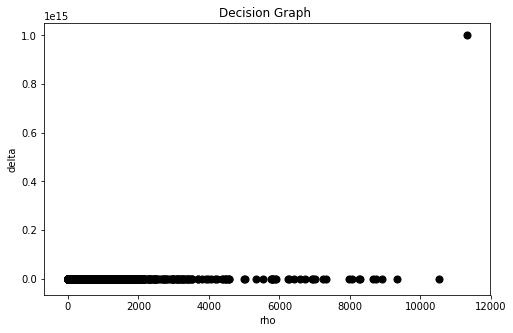

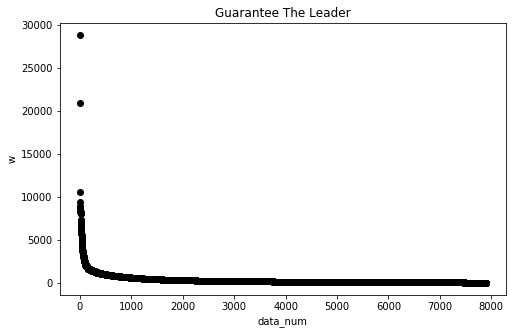

展示决策图
input clusters num5
mianly leaders: [7418, 115, 4197, 769, 7410]
选择簇心
修改之后的列表显示
               Lab          rho  delta   Q       w      close_coord
0  [187, 201, 163]    33.969978    1.0   1    33.0  [202, 194, 193]
1  [187, 201, 164]    41.100782    1.0   3    41.0  [202, 194, 193]
2  [187, 201, 166]    43.150989    1.0   2    43.0  [202, 194, 193]
3  [187, 201, 167]    45.126564    1.0   1    45.0  [202, 194, 193]
4  [187, 201, 168]    41.751939    1.0   2    41.0  [202, 194, 193]
5  [187, 201, 170]    27.573713    1.0   1    27.0  [202, 194, 193]
6  [187, 201, 202]  1555.569778    1.0  29  1555.0  [188, 202, 202]
7  [187, 201, 203]  1082.362424    1.0   3  1082.0  [188, 202, 202]
8  [187, 202, 162]    27.488365    1.0   5    27.0  [202, 194, 193]
9  [187, 202, 163]    54.236788    1.0  27    54.0  [202, 194, 193]
增加一列


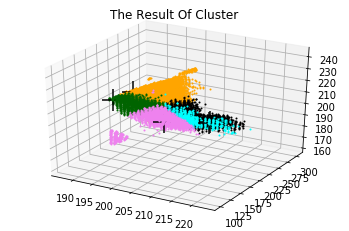

画图显示


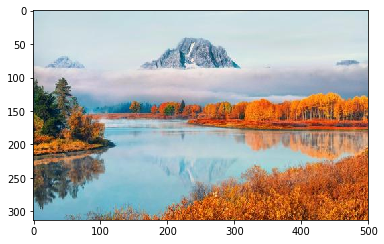

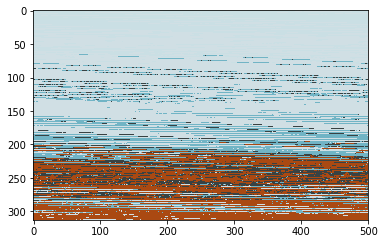

显示分类之后的图片


In [21]:
print("**************------------nature.jpg-------------*************************")
process("./nature.csv","./nature.jpg")

**************-------------streetview------------*************************
X.shape: (500, 748)
L_.shape: (500, 748)
a_.shape: (500, 748)
b_.shape: (500, 748)
找到所有坐标形成的二维矩阵
找到这些数据


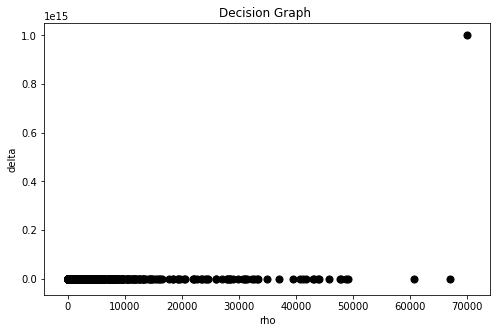

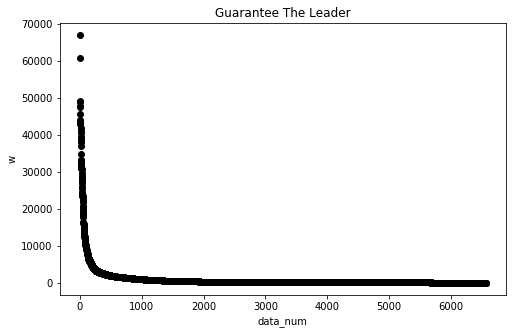

展示决策图
input clusters num4
mianly leaders: [157, 6481, 91, 251]
选择簇心
修改之后的列表显示
               Lab          rho      delta    Q        w      close_coord
0  [187, 202, 162]   783.941646   1.000000  338    783.0  [188, 202, 202]
1  [187, 202, 163]  1143.561604  34.928498  600  38862.0  [188, 202, 202]
2  [187, 202, 164]  1076.084294   1.000000  446   1076.0  [188, 202, 202]
3  [187, 202, 165]   785.577393   1.000000  274    785.0  [188, 202, 202]
4  [187, 202, 166]   548.125726   1.000000  176    548.0  [188, 202, 202]
5  [187, 202, 167]   403.498871   1.000000  164    403.0  [188, 202, 202]
6  [187, 202, 168]   285.841819   1.000000   95    285.0  [188, 202, 202]
7  [187, 202, 169]   193.847688   1.000000   62    193.0  [188, 202, 202]
8  [187, 202, 170]   135.315486   1.000000   46    135.0  [188, 202, 202]
9  [187, 202, 171]    93.487582   1.000000   31     93.0  [188, 202, 202]
增加一列


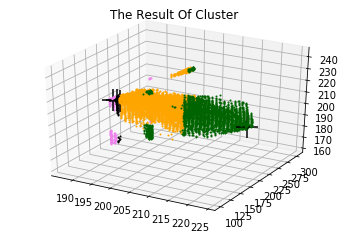

画图显示


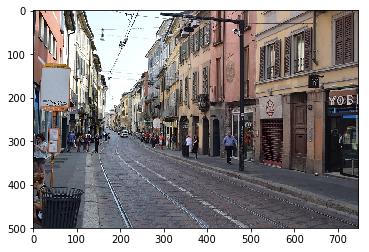

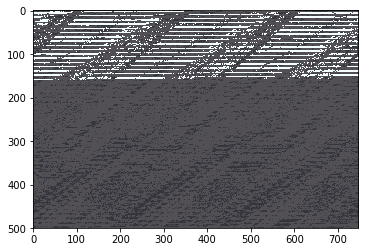

显示分类之后的图片


In [22]:
print("**************-------------streetview------------*************************")
process("./streetview.csv","./streetview.jpg")

**************----------lung_cancer.jpg---------------*************************
X.shape: (320, 322)
L_.shape: (320, 322)
a_.shape: (320, 322)
b_.shape: (320, 322)
找到所有坐标形成的二维矩阵
找到这些数据


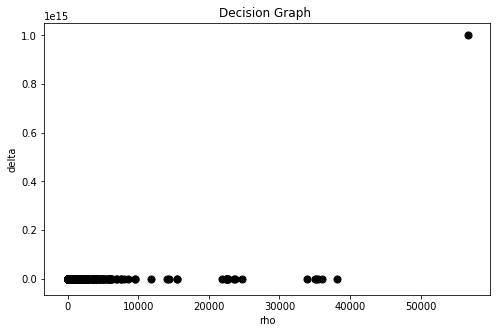

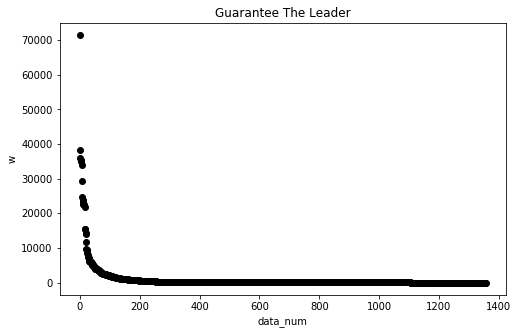

展示决策图
input clusters num11
mianly leaders: [730, 4, 25, 720, 823, 743, 729, 731, 671, 1231, 814]
选择簇心
修改之后的列表显示
               Lab          rho  delta     Q        w      close_coord
0  [126, 141, 101]   677.513338    1.0   150    677.0  [126, 141, 105]
1  [126, 141, 102]  1362.378349    1.0   414   1362.0  [126, 141, 105]
2  [126, 141, 103]  2045.258684    1.0   480   2045.0  [126, 141, 105]
3  [126, 141, 104]  2557.937498    1.0   852   2557.0  [126, 141, 105]
4  [126, 141, 105]  2772.854524   36.0   891  99792.0  [126, 141, 105]
5  [126, 141, 106]  2598.991727    1.0  1084   2598.0  [126, 141, 105]
6  [126, 141, 107]  1855.737881    1.0   722   1855.0  [126, 141, 105]
7  [126, 141, 108]   896.638390    1.0   136    896.0  [126, 141, 105]
8  [126, 141, 109]   316.301498    1.0    25    316.0  [126, 141, 105]
9  [126, 141, 110]   131.435373    1.0     7    131.0  [126, 141, 105]
增加一列


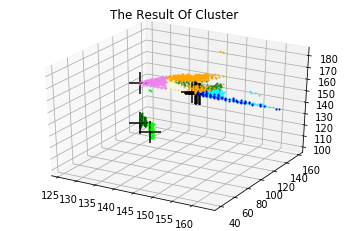

画图显示


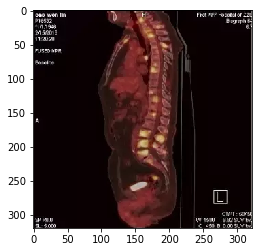

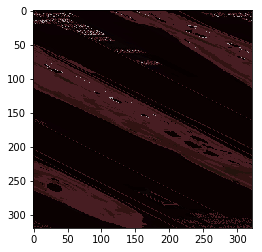

显示分类之后的图片


In [23]:
print("**************----------lung_cancer.jpg---------------*************************")
process("./lung_cancer.csv","./lung_cancer.png")

In [2]:
import numpy as np

In [3]:
# 一
a=[1, 2, 3]
b=[11, 22, 33]
np.column_stack((a,b))


array([[ 1, 11],
       [ 2, 22],
       [ 3, 33]])

In [4]:
# 二
np.column_stack(([[1],[2],[3]],[[11],[12],[13]]))



array([[ 1, 11],
       [ 2, 12],
       [ 3, 13]])

In [5]:

# 三
a_array = np.array([[1],[2],[3]])
b_array = np.array([[2],[3],[4]])
np.column_stack((a_array, b_array))


array([[1, 2],
       [2, 3],
       [3, 4]])